<a href="https://colab.research.google.com/github/MengOonLee/BertelsmannAITrack/blob/Lesson05/Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

26427392it [00:00, 53649127.50it/s]                              


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


32768it [00:00, 476323.83it/s]
  1%|          | 40960/4422102 [00:00<00:11, 375538.43it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


4423680it [00:00, 20624872.13it/s]                           
8192it [00:00, 150202.57it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


In [0]:
from torch import nn, optim
import torch.nn.functional as F

# Build a network architecture
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)

  def forward(self, x):
    # input tensor is flattened
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x), dim=1)
    return x

In [0]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [0]:
top_p, top_class = ps.topk(1, dim=1)
# The most likely classes for the first 10 samples
print(top_class[:10, :])

tensor([[6],
        [6],
        [6],
        [9],
        [9],
        [6],
        [9],
        [6],
        [6],
        [9]])


In [0]:
equals = top_class == labels.view(*top_class.shape)
equals.shape

torch.Size([64, 1])

In [0]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f"Accuracy: {accuracy.item()*100}%")

Accuracy: 10.9375%


In [0]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Train the network
epochs = 30
steps = 0
train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps, labels)    
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.512..  Test Loss: 0.488..  Test Accuracy: 0.820
Epoch: 2/30..  Training Loss: 0.391..  Test Loss: 0.420..  Test Accuracy: 0.849
Epoch: 3/30..  Training Loss: 0.355..  Test Loss: 0.391..  Test Accuracy: 0.857
Epoch: 4/30..  Training Loss: 0.329..  Test Loss: 0.367..  Test Accuracy: 0.870
Epoch: 5/30..  Training Loss: 0.316..  Test Loss: 0.393..  Test Accuracy: 0.864
Epoch: 6/30..  Training Loss: 0.302..  Test Loss: 0.351..  Test Accuracy: 0.873
Epoch: 7/30..  Training Loss: 0.287..  Test Loss: 0.389..  Test Accuracy: 0.869
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.402..  Test Accuracy: 0.864
Epoch: 9/30..  Training Loss: 0.273..  Test Loss: 0.392..  Test Accuracy: 0.866
Epoch: 10/30..  Training Loss: 0.267..  Test Loss: 0.362..  Test Accuracy: 0.876
Epoch: 11/30..  Training Loss: 0.260..  Test Loss: 0.369..  Test Accuracy: 0.876
Epoch: 12/30..  Training Loss: 0.250..  Test Loss: 0.411..  Test Accuracy: 0.866
Epoch: 13/30..  Training Loss: 0.250.

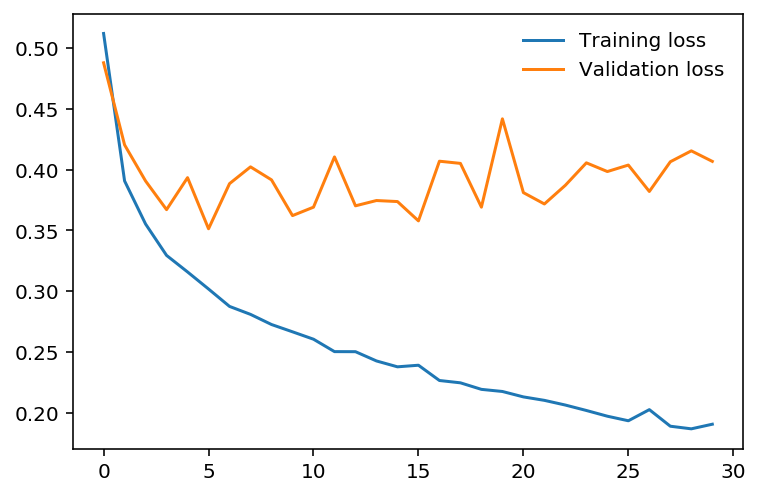

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.legend(frameon=False)